# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

2025-11-02 20:47:04.134865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762116424.356377      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762116424.410017      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing

## Dataset Paths

In [2]:
DATA_DIR = "/kaggle/input/gtsrb-german-traffic-sign"
TRAIN_DIR = "/kaggle/input/gtsrb-german-traffic-sign/Train"
TEST_DIR = "/kaggle/input/gtsrb-german-traffic-sign/Test"

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons' 
}

## Visualizing the Dataset

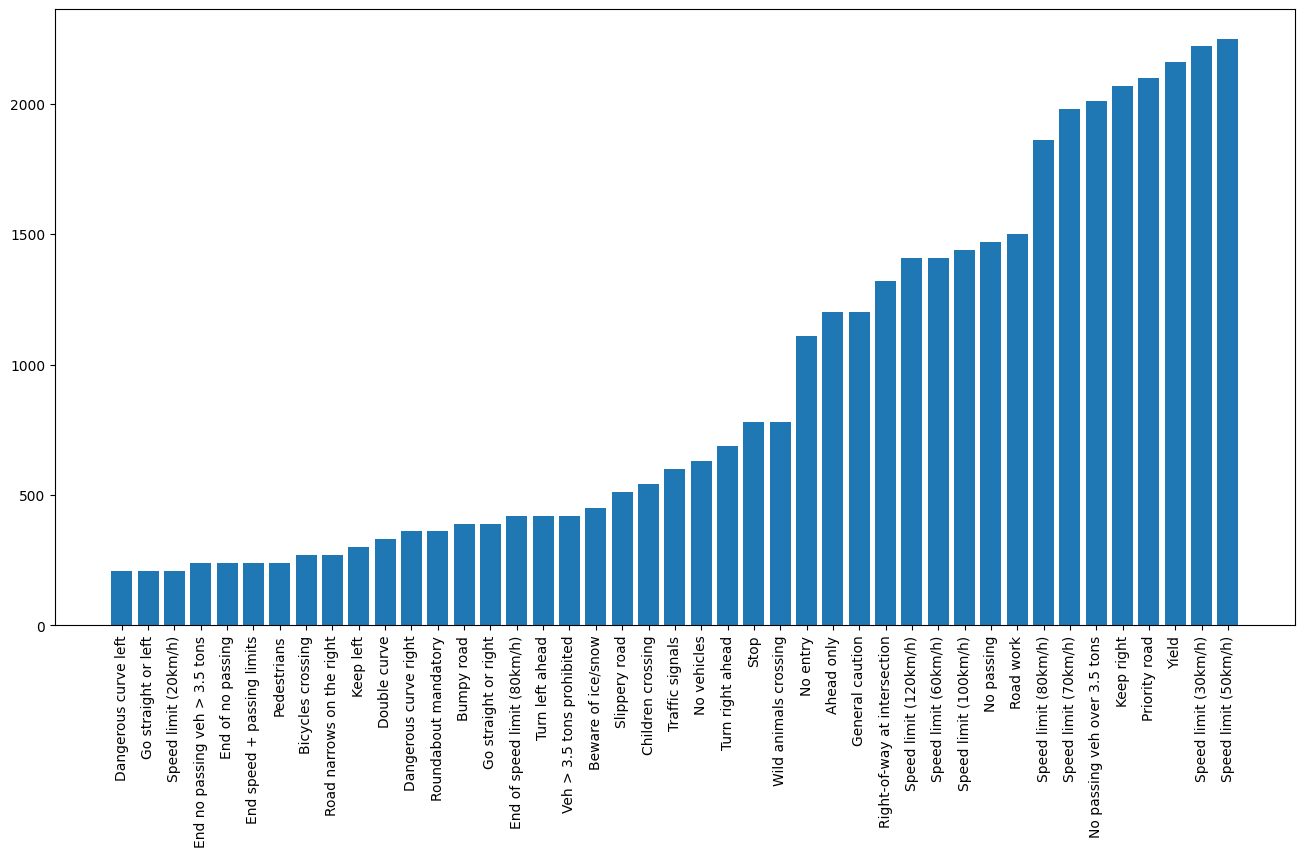

In [4]:
folders = os.listdir(TRAIN_DIR)
train_num = []
class_num = []

for folder in folders:
    train_files = os.listdir(os.path.join(TRAIN_DIR, folder))
    train_num.append(len(train_files))
    class_num.append(classes[int(folder)])

zipped_lists = zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_num, class_num = [ list(tuple) for tuple in  tuples]

# Plotting number of images in each class
plt.figure(figsize=(16, 8))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

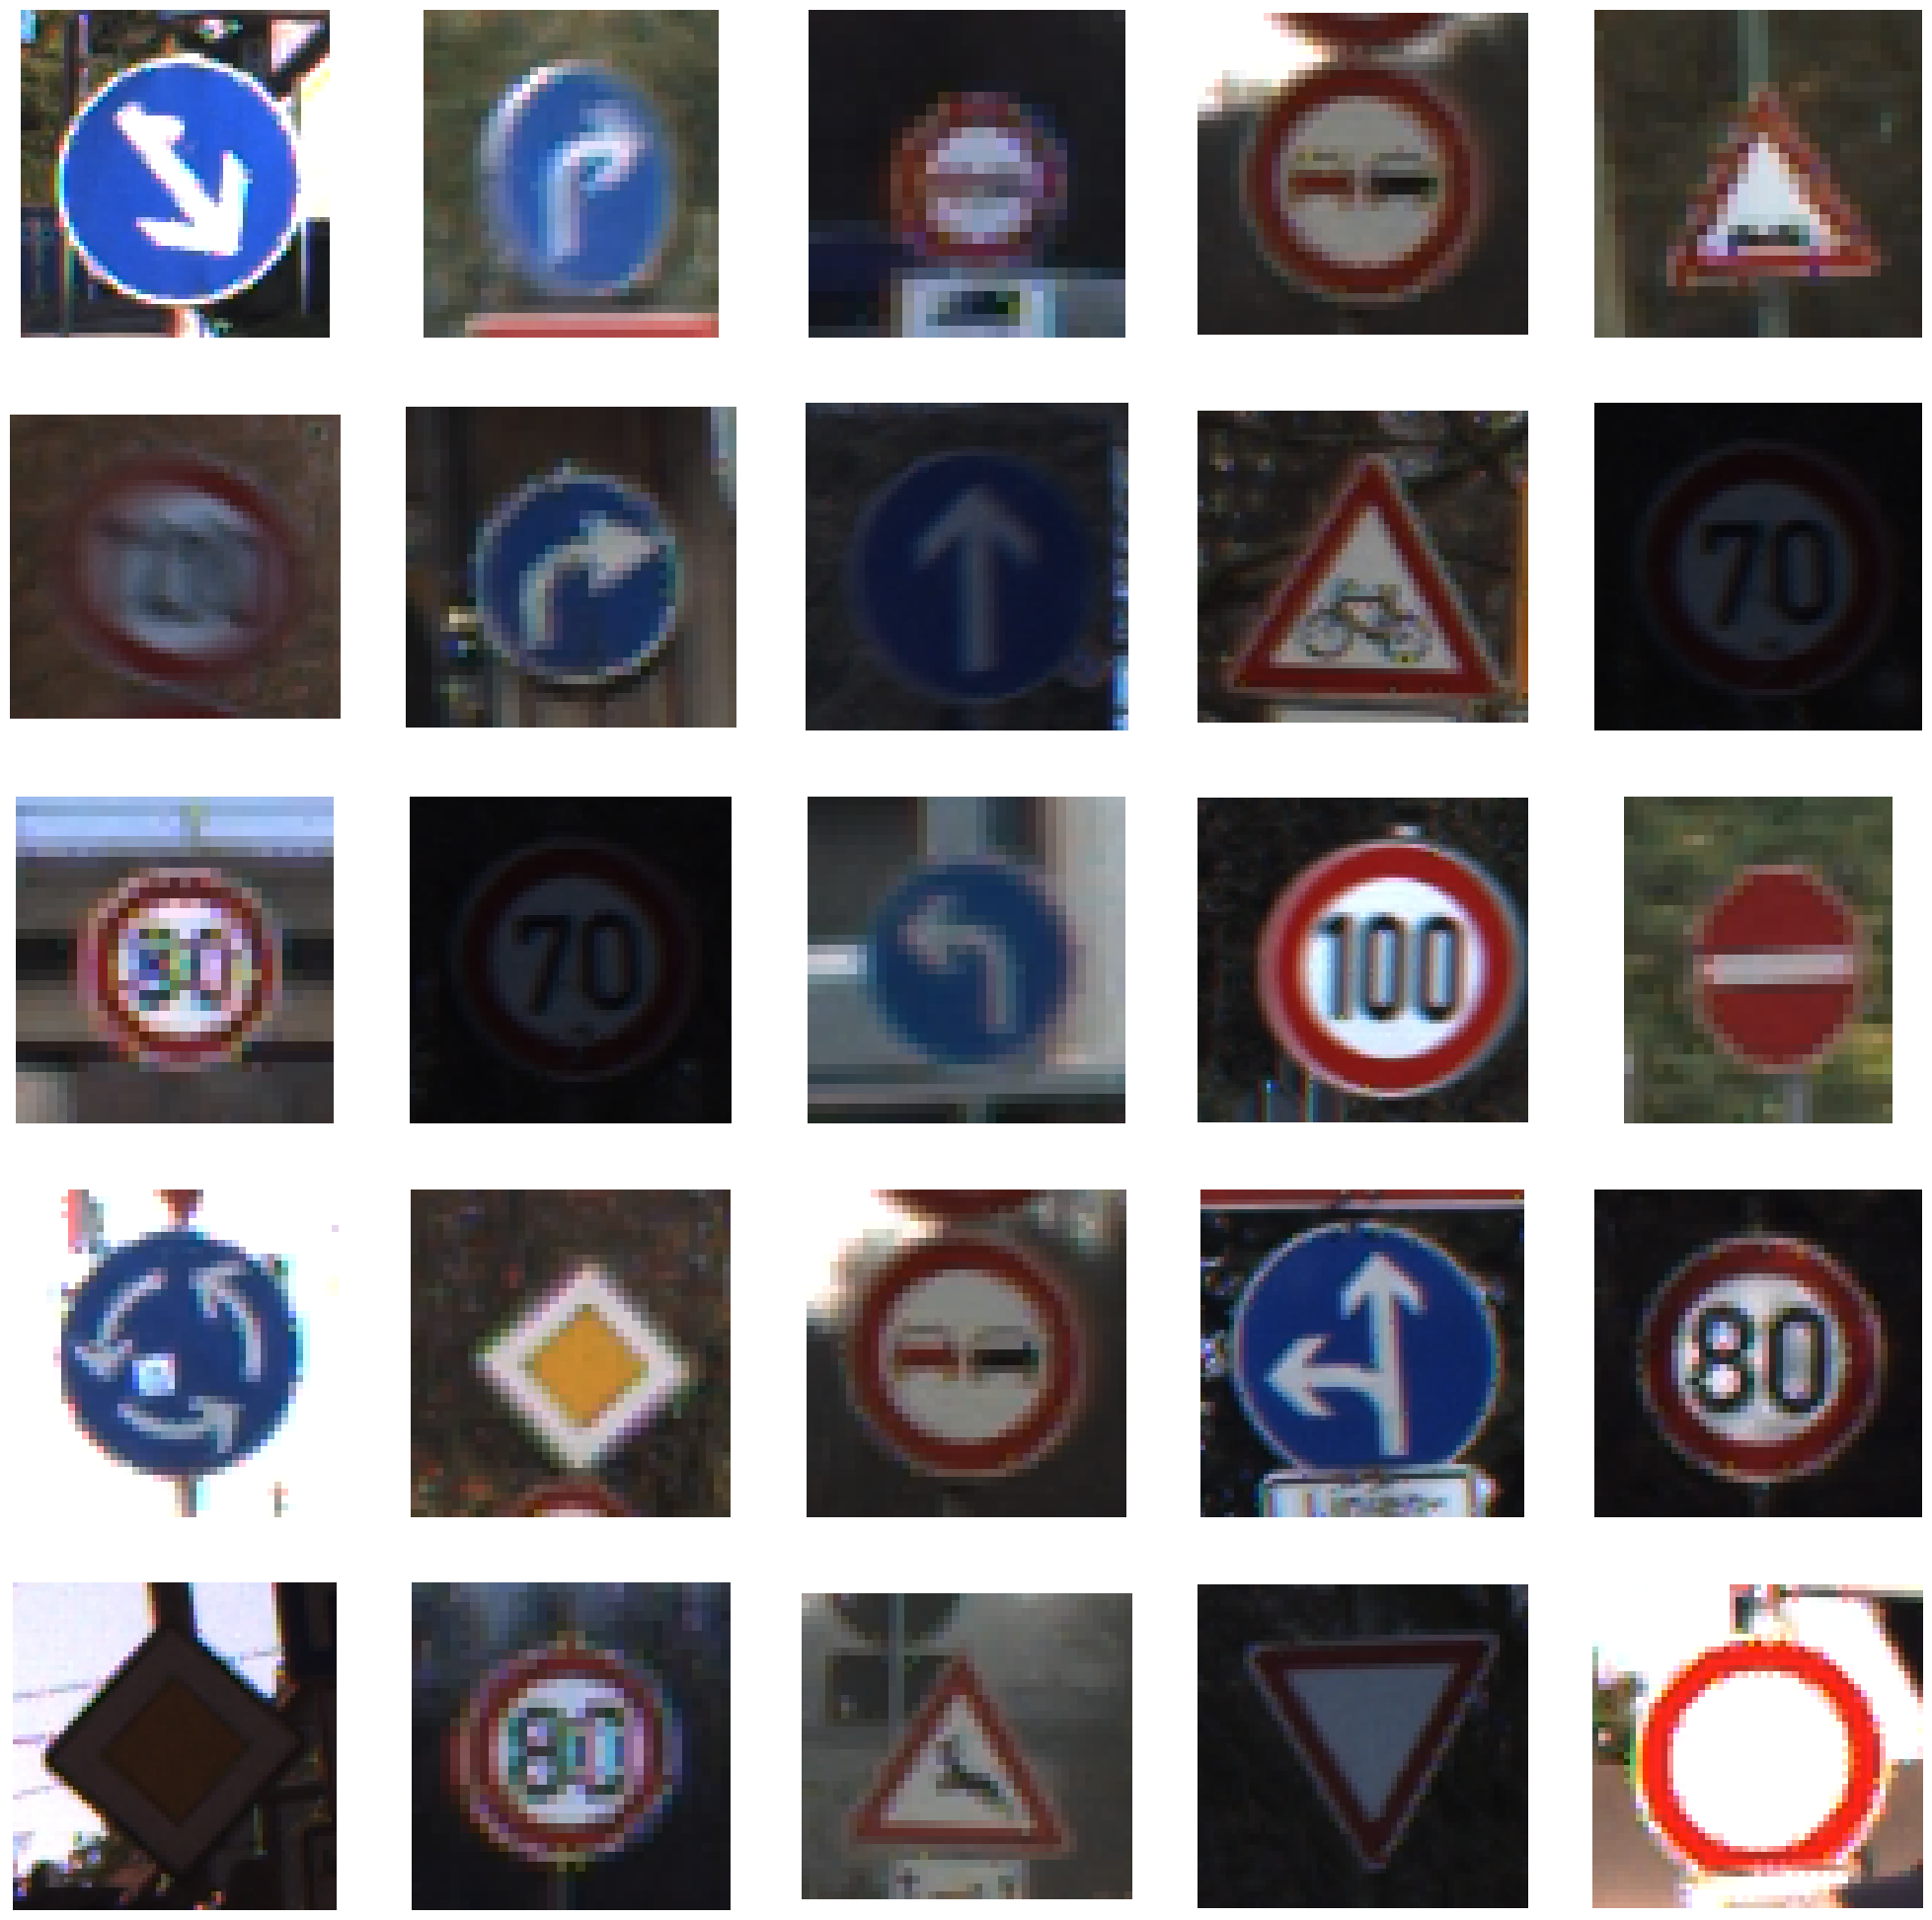

In [5]:
test = pd.read_csv(os.path.join(DATA_DIR, "Test.csv"))
imgs = test["Path"].values
plt.figure(figsize=(25, 25))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_img_path = os.path.join(DATA_DIR, random.choice(imgs))
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    # plt.grid(b=None)
    plt.axis("off")

## Collecting the Training Data

In [6]:
%%time
image_data = []
image_labels = []

for i in range(43):
    path = os.path.join(TRAIN_DIR, str(i))
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(os.path.join(path, img))
            image_fromarray = Image.fromarray(image, "RGB")
            resized_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resized_image))
            image_labels.append(i)
        except:
            print(f"Error in {img}")

# Changing lists to numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(f"Image Data -> {image_data.shape}")
print(f"Image Labels -> {image_labels.shape}")

<timed exec>:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)


Image Data -> (39209, 30, 30, 3)
Image Labels -> (39209,)
CPU times: user 12.7 s, sys: 5.58 s, total: 18.3 s
Wall time: 4min 3s


## Splitting the data into train and validation sets

In [7]:
# Shuffling the data
shuffled_indices = np.arange(image_data.shape[0])
np.random.shuffle(shuffled_indices)
print(shuffled_indices)
image_data = image_data[shuffled_indices]
image_labels = image_labels[shuffled_indices]

# Now let's split the data
X_train, X_valid, y_train, y_valid = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255.
X_valid = X_valid/255.

print("X_train ->", X_train.shape)
print("X_valid ->", X_valid.shape)
print("y_train ->", y_train.shape)
print("y_valid ->", y_valid.shape)

[24050 14757 23053 ...  3059 10371  2293]
X_train -> (27446, 30, 30, 3)
X_valid -> (11763, 30, 30, 3)
y_train -> (27446,)
y_valid -> (11763,)


## One Hot encoding the labels

In [8]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)

print("y_train ->", y_train.shape)
print("y_valid ->", y_valid.shape)

y_train -> (27446, 43)
y_valid -> (11763, 43)


# Model

## Building the Model

In [9]:
model = keras.models.Sequential([
    Input((IMG_HEIGHT, IMG_WIDTH, channels)),
    Conv2D(16, (5, 5)),
    Conv2D(32, (5, 5)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3)),
    Conv2D(128, (3, 3)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(43, activation='softmax')
])
model.summary()

I0000 00:00:1762116682.021719      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762116682.022502      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,195 (770.29 KB)

 Trainable params: 195,851 (765.04 KB)

 Non-trainable params: 1,344 (5.25 KB)

In [10]:
lr = 0.001
epochs = 20

opt = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.08)
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

In [11]:
augmentor = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [12]:
%%time
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(augmentor.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1762116687.996060      66 service.cc:148] XLA service 0x7a4cb00141a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762116687.996958      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762116687.996994      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762116688.473291      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


  9/858 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.0638 - loss: 4.7343

I0000 00:00:1762116692.763627      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.2705 - loss: 3.1136 - val_accuracy: 0.6983 - val_loss: 1.4602 - learning_rate: 0.0010
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6762 - loss: 1.6097 - val_accuracy: 0.8796 - val_loss: 1.1257 - learning_rate: 0.0010
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.7834 - loss: 1.3230 - val_accuracy: 0.9271 - val_loss: 0.9624 - learning_rate: 0.0010
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8304 - loss: 1.2036 - val_accuracy: 0.9601 - val_loss: 0.8727 - learning_rate: 0.0010
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8572 - loss: 1.1258 - val_accuracy: 0.9751 - val_loss: 0.8143 - learning_rate: 0.0010
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.8778 - loss: 1.0611 - val_accuracy: 0.9731 - val_loss: 0.7989 - learning_rate: 0.0010
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.8959 - loss: 1.0128

# Visualizing results

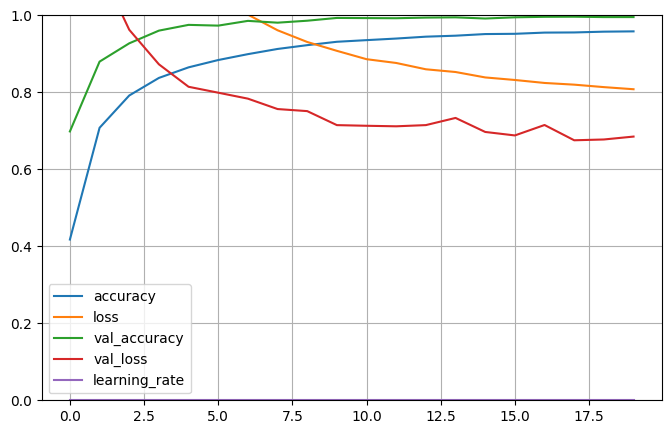

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Collecting Test Data and Evaluating the Model

In [14]:
test = pd.read_csv(os.path.join(DATA_DIR, 'Test.csv'))

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(os.path.join(DATA_DIR, img))
        image_fromarray = Image.fromarray(image, 'RGB')
        resized_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resized_image))
    except:
        print("Error in " + img)
        
X_test = np.array(data)
X_test = X_test/255.
labels = np.array(labels)
y_test = to_categorical(labels, 43)

/tmp/ipykernel_20/3936769919.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


In [15]:
model.evaluate(X_test, y_test)

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9701 - loss: 0.7340


[0.7342765927314758, 0.970546305179596]

### Visualizing the Confusion Matrix

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<Axes: >

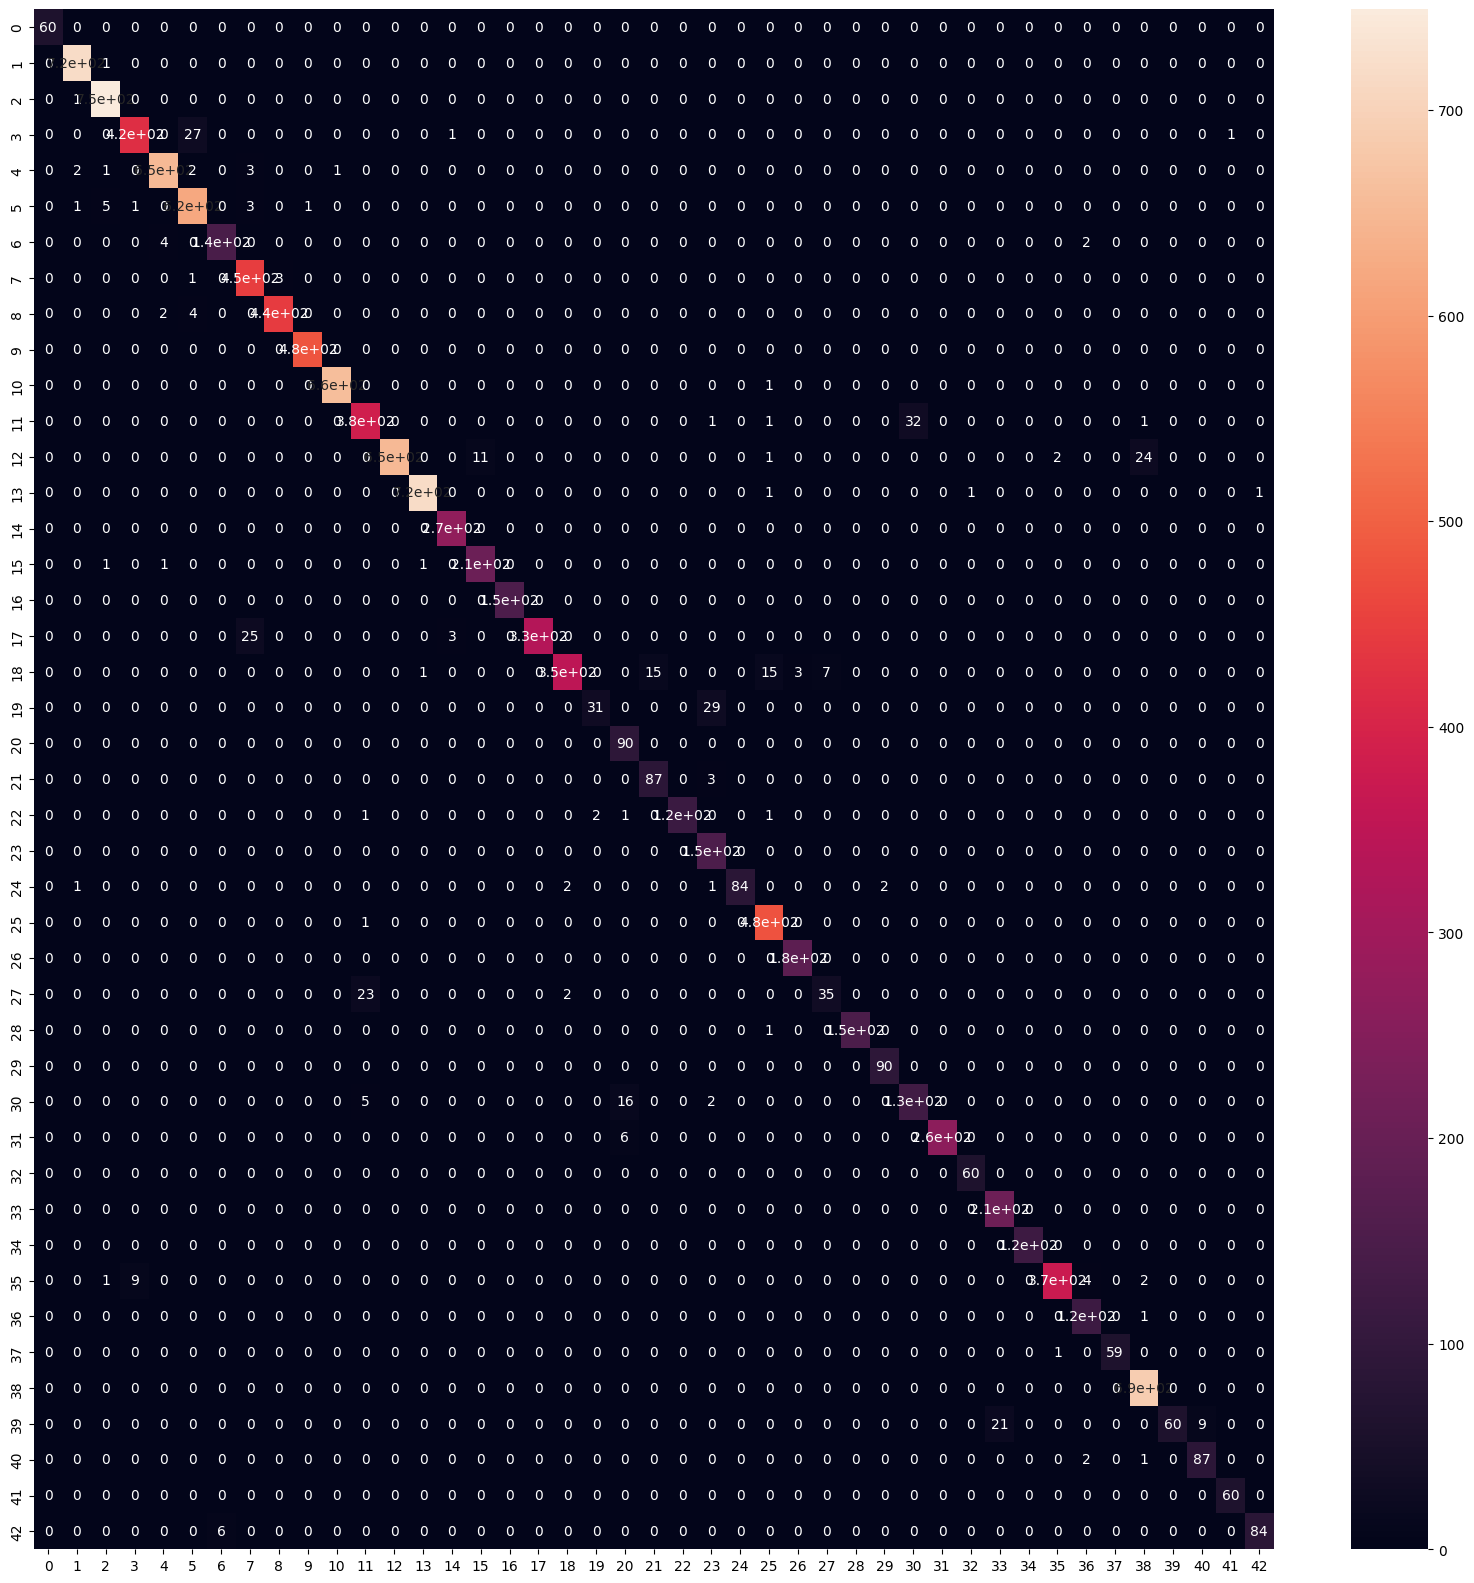

In [16]:
preds = model.predict(X_test)
cf = confusion_matrix(labels, np.argmax(preds, axis=1))

import seaborn as sns
df_cm = pd.DataFrame(cf, index=classes, columns=classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

### Classification Report

In [17]:
print(classification_report(labels, np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       0.98      0.94      0.96       450
           4       0.99      0.99      0.99       660
           5       0.95      0.98      0.96       630
           6       0.96      0.96      0.96       150
           7       0.94      0.99      0.96       450
           8       0.99      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.93      0.92      0.92       420
          12       1.00      0.94      0.97       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.95      0.99      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

# Now let's save our model

In [18]:
model.save("traffic_sign_model.h5")